# Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import os.path 

from __future__ import division
from __future__ import print_function

import cv2
import editdistance
import tensorflow as tf

import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Audio

!pip install gTTS
!pip install textblob

from textblob import TextBlob
from gtts import gTTS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Defining Functions

In [2]:
def cropping(filename):
  os.chdir('/content/drive/MyDrive/AIOT_Letters_Recognition/Images')
  global cropped
  kernel = np.ones((3, 3), np.uint8)
  img = cv2.imread(filename)
  img = cv2.resize(img, (0,0), fx=0.9, fy=0.9)
  filtered = cv2.bilateralFilter(img, 30, 80, 80)
  gray = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(filtered, (5, 5), 20)
  canny = cv2.Canny(blur, 50, 10)
  dilate = cv2.dilate(canny, kernel, iterations=23)

  contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  x_min = img.shape[1]
  y_min = img.shape[0]
  xw = 0
  yh = 0
  for cnt in contours:
      x1, y1, w1, h1 = cv2.boundingRect(cnt)
      if (x1 not in [0, img.shape[1]]) and (y1 not in [0, img.shape[0]]) and (w1 != img.shape[1] and w1 > 50) and (h1 != img.shape[0] and h1 > 50) and (cv2.contourArea(cnt) > 6000):
          rect = cv2.rectangle(dilate, (x1, y1), (x1 + w1, y1 + h1), (255, 255, 255), 10)
          if x1 < x_min:
              x_min = x1

          if y1 < y_min:
              y_min = y1

          if x1 + w1 > xw:
              xw = x1 + w1

          if y1 + h1 > yh:
              yh = y1 + h1
  cropped = img[y_min:yh, x_min:xw]
  cv2.imwrite('Cropped.png', cropped)

In [3]:
def recognize():
  import os
  os.chdir('/content/drive/MyDrive/AIOT_Letters_Recognition/src')
  from DataLoader import DataLoader, Batch
  from Model import Model, DecoderType
  from SamplePreprocessor import preprocess
  def infer(model, fnImg):
    global recognized, probability

    img = preprocess(cv2.imread(fnImg, cv2.IMREAD_GRAYSCALE), Model.imgSize)
    batch = Batch(None, [img])
    (recognized, probability) = model.inferBatch(batch, True)
    print('Recognized:', '"' + recognized[0] + '"')
    print('Probability:', probability[0])


  def main():
    decoderType = DecoderType.BestPath
    # infer text on test image
    model = Model(open('../model/charList.txt').read(), decoderType, mustRestore=True)
    infer(model, '../Images/Cropped.png')


  if __name__ == '__main__':
    tf.compat.v1.reset_default_graph()
    main()
    return recognized[0]

In [4]:
def speech(word, sound_file, correct_out):
  correct_out.append(str(TextBlob(word).correct()))
  tts = gTTS(str(TextBlob(word).correct()), lang = "en", slow = True)
  tts.save('1.wav')
  sound_file.append(str(size) + '.wav')

# Input

In [20]:
images = os.listdir('/content/drive/MyDrive/AIOT_Letters_Recognition/Images')
data = []
image_out = []
correct_out = []
accuracy_out = []
output = []
sound_file = []

size = 1


for filename in images:
  if filename.startswith("0"): 
    print(filename)
    data.append(filename)
filename = input("Enter the image file name:")

004.png
001.png
002.png
003.png
005.png
006.jpg
007.jpg
008.jpg
009.jpg
011.jpeg
010.jpg
012.jpg
013.jpg
014.jpeg
Enter the image file name:001.png


# Process

In [21]:

cropping(filename)
print("Cropping the image...")
word = recognize()
print("Recognizing the word...")
speech(word, sound_file, correct_out)

accuracy_out.append(round(probability[0]*1000)/10)
image_out.append(cropped)

Cropping the image...


/content/drive/MyDrive/AIOT_Letters_Recognition/src/Model.py:73: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  conv_norm = tf.compat.v1.layers.batch_normalization(conv, training=self.is_train)
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:455: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)


/content/drive/MyDrive/AIOT_Letters_Recognition/src/Model.py:86: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cells = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=numHidden, state_is_tuple=True) for _ in
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)


Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Tensorflow: 2.7.0
Init with stored values from ../model/snapshot-38
INFO:tensorflow:Restoring parameters from ../model/snapshot-38
Recognized: "Hello"
Probability: 0.7891848
Recognizing the word...


# Output

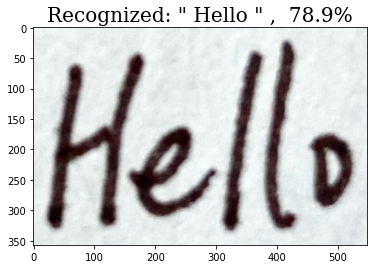

In [22]:
font = {'family': 'serif',
       'color':  'black',
       'weight': 'normal',
       'size': 20,
       }

plt.imshow(image_out[0])
plt.title('Recognized: " ' + correct_out[0] + ' " ' + ',  ' + str(accuracy_out[0]) + "%", fontdict=font)
Audio(sound_file[0], autoplay=True)

# Others

In [23]:
if False:
  Ans = input("Specific? Note That only specific produces audio. ")
  # L (Loop) is only for the self checking use, not for users.  
  if Ans == "L":
    for filename in images:
      if filename.startswith("0"): 
        print(filename)
        data.append(filename)
    for filename in data:
      cropping(filename)
      word = recognize()
      speech(word, sound_file, correct_out)

      accuracy_out.append(round(probability[0]*1000)/10)
      image_out.append(cropped)
      size += 1
    size -= 1

  if Ans == "S":
    for filename in images:
      if filename.startswith("0"): 
        print(filename)
        data.append(filename)
    filename = input("Enter the image file name:")
    cropping(filename)
    print("Cropping the image...")
    word = recognize()
    print("Recognizing the word...")
    speech(word, sound_file, correct_out)

    accuracy_out.append(round(probability[0]*1000)/10)
    image_out.append(cropped)
